In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Source

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

In [2]:
#y = pd.read_csv('data/archive/actual.csv') # method 2
y = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
train = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
test = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')
y.head()
train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [3]:
# Drop the call collumns from both data sets
call_cols_train = [col for col in train.columns if 'call' in col]
train = train.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in test.columns if 'call' in col]
test = test.drop(call_cols_test, axis = 1)

In [4]:
# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
train = train.drop(cols_to_drop, axis = 1)
test = test.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
train = train.T
test = test.T

train.index = pd.to_numeric(train.index) 
test.index = pd.to_numeric(test.index) 
train.sort_index(inplace=True) 
test.sort_index(inplace=True)

In [5]:
y['cancer'].value_counts() 

ALL    47
AML    25
Name: cancer, dtype: int64

'plt.figure(figsize=(8,8))\ncolors = ["AML", "ALL"]\nsns.countplot(\'cancer\', data=y[:38], palette = "Set1")\nplt.title(\'Class Distributions train data \n (0: AML || 1: ALL)\', fontsize=14)\n\nplt.figure(figsize=(8,8))\ncolors = ["AML", "ALL"]\nsns.countplot(\'cancer\', data=y[38:], palette = "Set1")\nplt.title(\'Class Distributions test data \n (0: AML || 1: ALL)\', fontsize=14)'

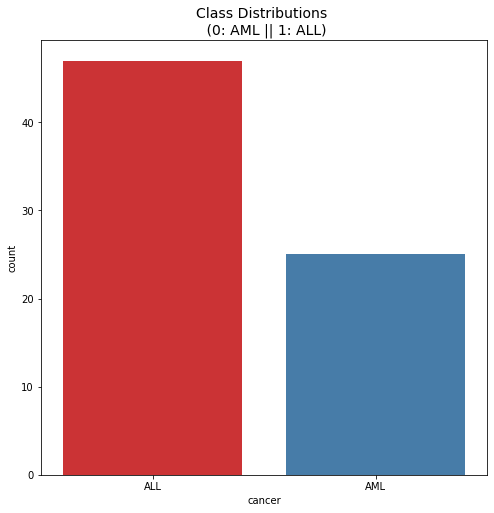

In [6]:
plt.figure(figsize=(8,8))
colors = ["AML", "ALL"]
sns.countplot('cancer', data=y, palette = "Set1")
plt.title('Class Distributions \n (0: AML || 1: ALL)', fontsize=14)

'''plt.figure(figsize=(8,8))
colors = ["AML", "ALL"]
sns.countplot('cancer', data=y[:38], palette = "Set1")
plt.title('Class Distributions train data \n (0: AML || 1: ALL)', fontsize=14)

plt.figure(figsize=(8,8))
colors = ["AML", "ALL"]
sns.countplot('cancer', data=y[38:], palette = "Set1")
plt.title('Class Distributions test data \n (0: AML || 1: ALL)', fontsize=14)'''

In [7]:
y = y.replace({'ALL':0,'AML':1})
y

,cancer
patient,
1,0
2,0
3,0
4,0
5,0
...,...
68,0
69,0
70,0


In [8]:
X_train = train.reset_index(drop=True)
y_train = y[y.index <= 38].reset_index(drop=True) 

X_test = test.reset_index(drop=True)
y_test= y[y.index > 38].reset_index(drop=True)

In [19]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

array([[-1.83200476e+04, -1.86520880e+04, -1.48349220e+04, ...,
         9.33042007e+03,  4.95460273e+03,  7.57098485e+02],
       [-1.81429573e+04, -9.94139813e+03, -2.66523710e+04, ...,
         8.28614550e+03, -1.35428120e+01,  1.88685733e+03],
       [-2.53032722e+04,  3.33430647e+03, -7.98636056e+03, ...,
         3.62568413e+03, -1.00552863e+03,  6.93300062e+01],
       ...,
       [-3.61389735e+04, -2.06160688e+04, -1.25179855e+04, ...,
        -2.13485321e+03, -3.22041843e+03, -1.26922039e+03],
       [-2.32770823e+03, -9.98961620e+01, -1.74562856e+04, ...,
         6.54809303e+02,  3.33069069e+03, -2.77261566e+02],
       [-7.73754226e+03,  1.60414859e+03, -2.23167909e+04, ...,
         1.02172105e+03, -2.67142055e+00,  8.70516321e+02]])

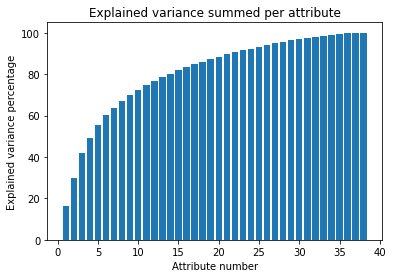

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 21 attributes that together explain 90% of the variance.


In [10]:
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio*100
#Calculate and plot explained variance PCA
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio * 100
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print('''Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.''')

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i < 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

In [11]:
#method 2
#y_test = y_test.iloc[:,1]
#y_train = y_train.iloc[:,1].values 
#y_train

In [17]:
tree_clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4)
tree_clf = tree_clf.fit(X_train_pca, y_train)
prediction=tree_clf.predict(X_test_pca)
accuracy = metrics.accuracy_score(y_test, prediction)
print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

The standard decision tree has an accuracy of 0.7941176470588235 and an error rate of 0.20588235294117652.
